In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [4]:
%reload_ext autoreload
%autoreload 2
%aimport constants
%aimport file_parser
%aimport bs_lib

In [53]:
from os.path import join, isfile
import constants as cnst
import numpy as np
import tensorflow as tf

# Own lib
import file_parser as parser
import bs_lib.bs_preprocess_lib as bsp
import bs_lib.bs_image as bima
import bs_lib.bs_eda as beda
import bs_lib.bs_cnn as cnn
from bs_lib.classes.H5DataGenerator import H5DataGenerator

np.random.seed(1)

## Split Data

original .npy files data into train, val and test set

In [69]:
original_files = beda.get_list_dir(in_directory_path=cnst.ORIGINAL_DATA_PATH,
    with_extension='.npy',
    match_terms=[],
    exclude_terms=[],
    separator='.',
    verbose=False)

In [ ]:
image_shape = (-1, 28, 28)
for key, filename in original_files.items():
    file_path = os.path.join(cnst.ORIGINAL_DATA_PATH, filename)
    category = parser.get_category_name(filename)
    images = np.load(file_path)
    nb_rows, size_flat_image = images.shape
    X_train, X_val, X_test, _, _, _ = parser.train_val_test_split(
        images, category, verbose=False)
    # create {category}.npy files in train_set directory
    parser.save_as_binary(images, as_filename=f"{category}.npy", into_directory=join(
        cnst.TRAIN_DATA_DIR_PATH), verbose=False)
    # create {category}.npy files in val_set directory
    parser.save_as_binary(images, as_filename=f"{category}.npy", into_directory=join(
        cnst.VAL_DATA_DIR_PATH), verbose=False)
    # create {category}.npy files in test_set directory
    parser.save_as_binary(images, as_filename=f"{category}.npy", into_directory=join(
        cnst.TEST_DATA_DIR_PATH), verbose=False)

## Display some samples

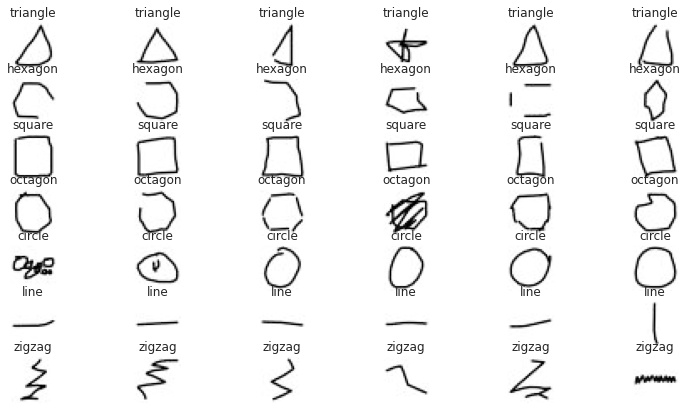

In [85]:
images, images_categories = parser.get_samples(from_directory=cnst.TRAIN_DATA_DIR_PATH,nb_samples=6)
parser.plot_images(images, images_categories)

## Remove Outliers

Using IsolationForest

In [6]:
train_set_files = beda.get_list_dir(in_directory_path=cnst.TRAIN_DATA_DIR_PATH,
    with_extension='.npy',
    match_terms=[],
    exclude_terms=['outlier_filtered'],
    separator='.',
    verbose=False)

In [ ]:
image_shape = (-1, 28, 28)
images_sample = []
images_category = []
for category, filename in train_set_files.items():
    outlier_filtered_file = join(cnst.TRAIN_DATA_DIR_PATH, f"outlier_filtered_{category}.npy")
    # if there's no outlier filtered file for current category
    if not isfile(outlier_filtered_file):
        # create an "outliers_filtered" npy file
        file_path = join(cnst.TRAIN_DATA_DIR_PATH, filename)
        all_images = parser.get_rows_from(file_path)
        filtered_images = parser.remove_outlier(all_images, verbose=False)
        np.save(outlier_filtered_file,arr=filtered_images)
    else: 
        filtered_images = parser.get_rows_from(outlier_filtered_file)
    # displays some random samples of outliers filtered images
    nb_sample = 6
    idx = np.random.choice(filtered_images.shape[0], nb_sample, replace=False)
    filtered_images = filtered_images.reshape(image_shape)
    images_sample.extend(filtered_images[idx])
    category_sample = np.full(nb_sample,category)
    images_category.extend(category_sample)

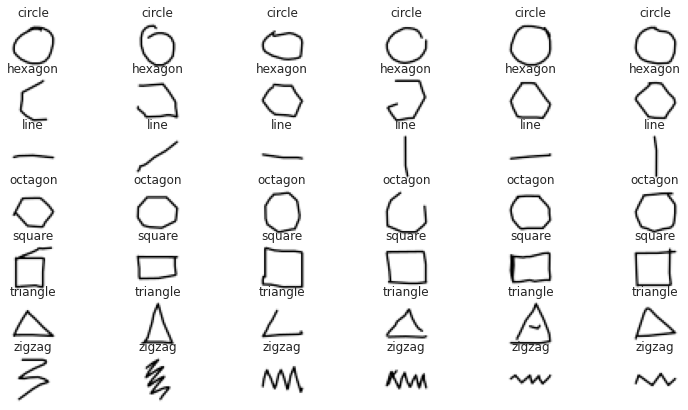

In [8]:
parser.plot_images(images_sample, images_category,verbose=False)

## Balancing Dataset

In [ ]:
oftsf = beda.get_list_dir(in_directory_path=cnst.TRAIN_DATA_DIR_PATH,
    with_extension='.npy',
    match_terms=['outlier_filtered'],
    exclude_terms=[],
    separator='.',
    verbose=False)
# search for the smallest dataset
smallest_dataset_size = 200000
for filename, file in oftsf.items():
    file_path = join(cnst.TRAIN_DATA_DIR_PATH, file)
    f = np.load(file_path)
    if f.shape[0]<smallest_dataset_size:
        smallest_dataset_size = f.shape[0]
for filename, file in oftsf.items():
    file_path = join(cnst.TRAIN_DATA_DIR_PATH, file)
    images = np.load(file_path)
    if images.shape[0]>smallest_dataset_size:
        # crop file
        images = images[:smallest_dataset_size]
        parser.save_as_binary(images, as_filename=file, into_directory=join(
        cnst.TRAIN_DATA_DIR_PATH), verbose=False)

In [10]:
oftsf = beda.get_list_dir(in_directory_path=cnst.TRAIN_DATA_DIR_PATH,
    with_extension='.npy',
    match_terms=['outlier_filtered'],
    exclude_terms=[],
    separator='.',
    verbose=False)
for filename, file in oftsf.items():
    file_path = join(cnst.TRAIN_DATA_DIR_PATH, file)
    f = np.load(file_path)

(106631, 784)
(106631, 784)
(106631, 784)
(106631, 784)
(106631, 784)
(106631, 784)
(106631, 784)


## Merge all categories data into one dataset

In [43]:
labels_dict = {'triangle': 0, 'circle': 1, 'hexagon': 2,
               'line': 3, 'octagon': 4, 'square': 5, 'zigzag': 6}

### Create Train set as hdf5 file

In [46]:
train_set_h5_file_path = parser.create_dataset('train_set',
                                               from_directory_path=cnst.TRAIN_DATA_DIR_PATH,
                                               labels_dict=labels_dict,
                                               match_terms=['outlier_filtered'],
                                               exclude_terms=[],
                                               verbose=False)

### Create Val Set as hdf5 file

In [59]:
val_set_h5_file_path = parser.create_dataset('val_set',
                                               from_directory_path=cnst.VAL_DATA_DIR_PATH,
                                               labels_dict=labels_dict,
                                               match_terms=[],
                                               exclude_terms=[],
                                               verbose=False)

### Create Test set as hdf5 file

In [61]:
test_set_h5_file_path = parser.create_dataset('test_set',
                                               from_directory_path=cnst.TEST_DATA_DIR_PATH,
                                               labels_dict=labels_dict,
                                               match_terms=[],
                                               exclude_terms=[],
                                               verbose=False)

## Create Data Generator

In [ ]:
params = {'dim': (28, 28),
          'batch_size': 128,
          'n_classes': 7,
          'n_channels': 1,
          'shuffle': True}

### Train set generator

In [49]:
train_data_generator = H5DataGenerator(train_set_h5_file_path, **params)

### Val Set Generator

In [62]:
val_data_generator = H5DataGenerator(val_set_h5_file_path, **params)

### Test Set Generator

In [63]:
test_data_generator = H5DataGenerator(test_set_h5_file_path, **params)

## Create the Model

In [18]:
img_width=28
img_height=28

In [66]:
model = cnn.get_cnn(n_classes=7,
                      kernel_size=3,
                      filters_size=[128,256],
                      pooling_size=2,
                      layers=[8, 8],
                      input_shape=(img_width, img_height,1),
                      activation='relu',
                      loss='categorical_crossentropy')

## Training the model

In [67]:
history = model.fit(train_data_generator, validation_data=val_data_generator, epochs=10)

Epoch 1/10
5831/5831 [==============================] - 4139s 710ms/step - loss: 1.1131 - accuracy: 0.5543 - val_loss: 0.4949 - val_accuracy: 0.8540
Epoch 2/10
5831/5831 [==============================] - 4364s 748ms/step - loss: 0.2690 - accuracy: 0.8958 - val_loss: 0.4490 - val_accuracy: 0.8704
Epoch 3/10
5831/5831 [==============================] - 4337s 743ms/step - loss: 0.2451 - accuracy: 0.9046 - val_loss: 0.4432 - val_accuracy: 0.8755
Epoch 4/10
5831/5831 [==============================] - 4335s 743ms/step - loss: 0.2342 - accuracy: 0.9091 - val_loss: 0.4503 - val_accuracy: 0.8778
Epoch 5/10
5831/5831 [==============================] - 4331s 742ms/step - loss: 0.2268 - accuracy: 0.9118 - val_loss: 0.4537 - val_accuracy: 0.8761
Epoch 6/10
5831/5831 [==============================] - 4364s 747ms/step - loss: 0.2203 - accuracy: 0.9138 - val_loss: 0.4255 - val_accuracy: 0.8782
Epoch 7/10
5831/5831 [==============================] - 4316s 740ms/step - loss: 0.2165 - accuracy: 0.9156

In [68]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        9280      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


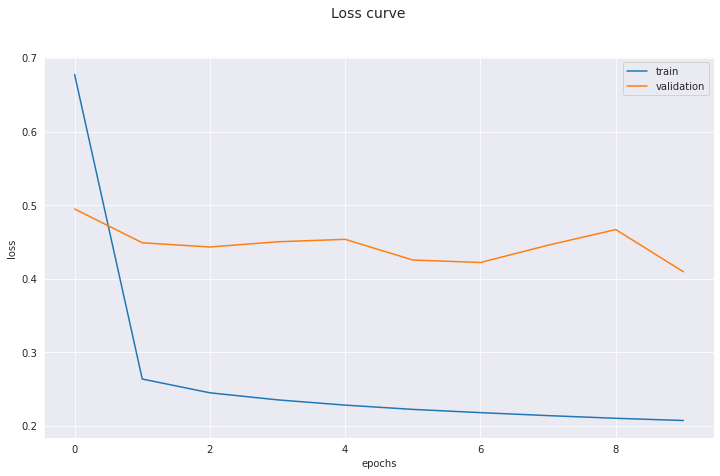

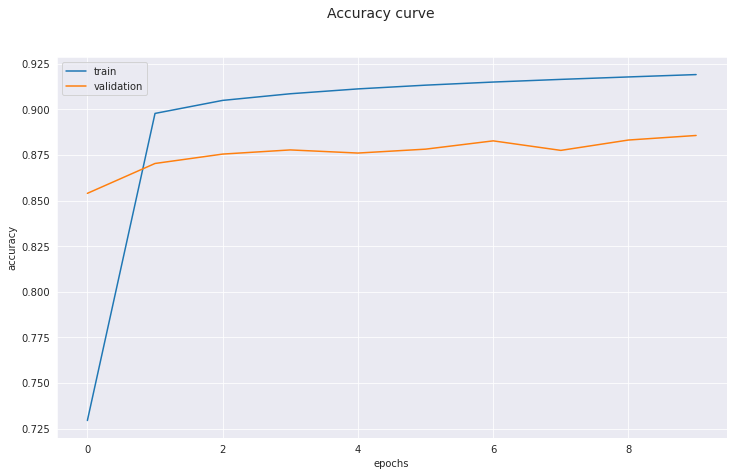

In [69]:
bsp.get_nn_learning_curve(history.history)

## Saving the model

In [ ]:
model_name = 'model_l8X8_f16-64_128_p2_k3'
model_path = join(cnst.MODEL_DIR_PATH,model_name)

In [ ]:
model.save(model_path)

## Loading Model

In [ ]:
model = tf.keras.models.load_model(model_path)

## Testing Prediction

In [71]:
loss, acc = model.evaluate(test_data_generator, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

7318/7318 - 2450s - loss: 0.4096 - accuracy: 0.8857
Restored model, accuracy: 88.57%
